In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("font", size=14)
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
import seaborn as sns
sns.set()
sns.set(style="whitegrid", color_codes=True)
from tqdm.notebook import tqdm
tqdm.pandas()

In [2]:
csv_akam = "C:/Business analysis/Project/IS403.O22.HTCLL_Nhom07/Dataset/AKAM_Stock.csv"
df_akam = pd.read_csv(csv_akam, thousands=',')

In [3]:
df_akam.head()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
0,3/1/2019,AKAM,71.089996,71.089996,71.489998,69.739998,70.059998,1633700
1,3/4/2019,AKAM,70.290001,70.290001,71.790001,69.709999,71.550003,995000
2,3/5/2019,AKAM,70.550003,70.550003,70.989998,69.800003,70.209999,1282100
3,3/6/2019,AKAM,71.540001,71.540001,71.680000,70.510002,70.620003,1658400
4,3/7/2019,AKAM,70.470001,70.470001,71.150002,70.019997,71.089996,1353400


In [4]:
df_akam.describe()

,Adj Close,Close,High,Low,Open,Volume
count,1324.000000,1324.000000,1324.000000,1324.000000,1324.000000,1.324000e+03
mean,98.894456,98.894456,99.920030,97.838044,98.871488,1.582324e+06
std,13.155544,13.155544,13.238076,13.092423,13.186564,9.565868e+05
min,69.120003,69.120003,69.260002,67.279999,68.230003,2.774000e+05
25%,88.715000,88.715000,89.742500,87.667500,88.660004,1.043800e+06
50%,100.404999,100.404999,101.779999,99.184998,100.419998,1.350500e+06
75%,110.002501,110.002501,111.330000,108.862501,109.972502,1.799050e+06
max,128.320007,128.320007,129.169998,126.980003,128.550003,1.077170e+07


In [5]:
df_akam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324 entries, 0 to 1323
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1324 non-null   object 
 1   Symbol     1324 non-null   object 
 2   Adj Close  1324 non-null   float64
 3   Close      1324 non-null   float64
 4   High       1324 non-null   float64
 5   Low        1324 non-null   float64
 6   Open       1324 non-null   float64
 7   Volume     1324 non-null   int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 82.9+ KB


In [6]:
# Convert object to datetime64
df_akam['Date'] = df_akam['Date'].apply(pd.to_datetime)
# Sort data by date time value
df_akam = df_akam.sort_values(by="Date").reset_index(drop=True)
df_akam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324 entries, 0 to 1323
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1324 non-null   datetime64[ns]
 1   Symbol     1324 non-null   object        
 2   Adj Close  1324 non-null   float64       
 3   Close      1324 non-null   float64       
 4   High       1324 non-null   float64       
 5   Low        1324 non-null   float64       
 6   Open       1324 non-null   float64       
 7   Volume     1324 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 82.9+ KB


In [7]:
df_akam.Close

0       71.089996
1       70.290001
2       70.550003
3       71.540001
4       70.470001
          ...    
1319    92.589996
1320    90.839996
1321    90.220001
1322    92.239998
1323    90.900002
Name: Close, Length: 1324, dtype: float64

In [8]:
rows = []
for _,row in tqdm(df_akam.iterrows(), total=df_akam.shape[0]):
    row_data = dict(
        date = row.Date,
        open = row.Open,
        low = row.Close,
        high = row.High, 
        close = row.Close, 
        volume = row.Volume,
    )
    rows.append(row_data)
features_akam = pd.DataFrame(rows)

  0%|          | 0/1324 [00:00<?, ?it/s]

In [9]:
features_akam.head()

,date,open,low,high,close,volume
0,2019-03-01,70.059998,71.089996,71.489998,71.089996,1633700
1,2019-03-04,71.550003,70.290001,71.790001,70.290001,995000
2,2019-03-05,70.209999,70.550003,70.989998,70.550003,1282100
3,2019-03-06,70.620003,71.540001,71.680000,71.540001,1658400
4,2019-03-07,71.089996,70.470001,71.150002,70.470001,1353400


In [10]:
def detect_outlier(df, col):
    q1 = np.percentile(df[col], 25)
    q3 = np.percentile(df[col], 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    print(df[(df[col] < lower_bound) | (df[col] > upper_bound)])

In [11]:
detect_outlier(features_akam, 'close')

Empty DataFrame
Columns: [date, open, low, high, close, volume]
Index: []


In [12]:
features_akam = features_akam.set_index("date")
features_akam.head()

,open,low,high,close,volume
date,,,,,
2019-03-01,70.059998,71.089996,71.489998,71.089996,1633700
2019-03-04,71.550003,70.290001,71.790001,70.290001,995000
2019-03-05,70.209999,70.550003,70.989998,70.550003,1282100
2019-03-06,70.620003,71.540001,71.680000,71.540001,1658400
2019-03-07,71.089996,70.470001,71.150002,70.470001,1353400


In [13]:
train_size = int(0.75 * len(features_akam))
test_size = len(features_akam)-train_size

train_akam_df = features_akam[:train_size]
test_akam_df = features_akam[train_size:]

Text(0.5, 1.0, 'Time Series Plots of akam stock')

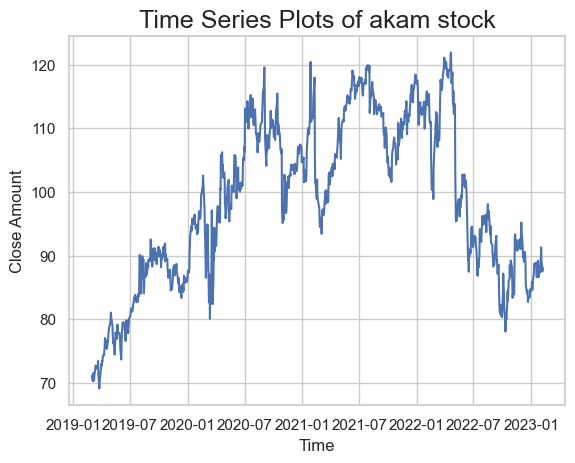

In [14]:
fig, ax = plt.subplots()
ax.plot(train_akam_df.index, train_akam_df['close'])
ax.set_ylabel('Close Amount')
ax.set_xlabel('Time')
ax.set_title('Time Series Plots of akam stock', size=18)

The additive method is useful when the trend and seasonal variation is relatively constant over time as shown below whereas the multiplicative method is useful when the trend and seasonal variation increases or decreases in magnitude over time

Text(0.5, 0, 'Y')

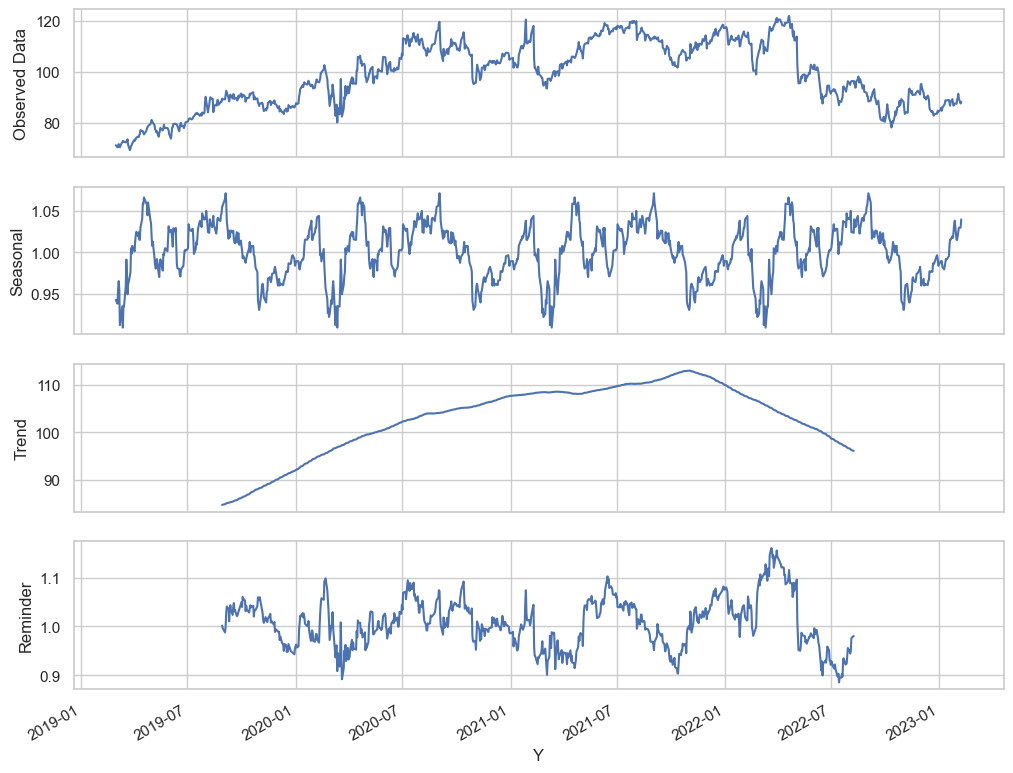

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
res = seasonal_decompose(train_akam_df['close'], model='multiplicative', period=252)

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(12,10), sharex= True)
res.observed.plot(ax=ax1)
ax1.set_ylabel('Observed Data')
res.seasonal.plot(ax=ax2)
ax2.set_ylabel('Seasonal')
res.trend.plot(ax=ax3)
ax3.set_ylabel('Trend')
res.resid.plot(ax=ax4)
ax4.set_ylabel('Reminder')

plt.xlabel("Y")

In [16]:
# Define your parameter grid
param_grid = {
    'error': ['add', 'mul'],
    'trend': ['add','mul', None],
    'damped_trend': [False, True],
    'seasonal': ['add', None, 'mul'],
    'seasonal_periods': [7, 14, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 365]
}

# Initialize variables to store the best score, parameters, and model
best_aic = float('inf')
best_params = None
best_model = None

# Ensure the data passed to ETSModel is 1-dimensional and has date index with frequency
train_series = pd.Series(train_akam_df['close'].values, index=pd.date_range(start=train_akam_df.index[0], periods=len(train_akam_df), freq='D'))
test_series = pd.Series(test_akam_df['close'].values, index=pd.date_range(start=test_akam_df.index[0], periods=len(test_akam_df), freq='D'))

# Iterate over all combinations of parameters
for error in param_grid['error']:
    for trend in param_grid['trend']:
        damped_trend_values = [False] if trend is None else param_grid['damped_trend']
        for damped_trend in damped_trend_values:
            for seasonal in param_grid['seasonal']:
                for seasonal_periods in param_grid['seasonal_periods']:
                    try:
                        # Check if seasonal_periods is valid with the given seasonal component
                        if seasonal is None and seasonal_periods is not None:
                            continue
                        
                        # Define and fit the model
                        model = ETSModel(train_series, 
                                         error=error,
                                         trend=trend,
                                         damped_trend=damped_trend, 
                                         seasonal=seasonal, 
                                         seasonal_periods=seasonal_periods,
                                         initialization_method='heuristic')
                        model_fit = model.fit()

                        # Make predictions with date index preserved
                        # Get AIC score
                        aic_score = model_fit.aic
                        
                        # Update the best model if the current one has lower AIC
                        if aic_score < best_aic:
                            best_aic = aic_score
                            best_params = {
                                'error': error,
                                'trend': trend,
                                'damped_trend': damped_trend,
                                'seasonal': seasonal,
                                'seasonal_periods': seasonal_periods
                            }
                            best_model = model_fit

                    except Exception as e:
                        print(f"An error occurred for parameters (error={error}, trend={trend}, damped_trend={damped_trend}, seasonal={seasonal}, seasonal_periods={seasonal_periods}): {e}")
                        continue

# Output the best model's AIC
if best_model is not None:
    print('Best model')
    print(f"Best Parameters: {best_params}")
    print(f"Best AIC: {best_aic}")

Best model
Best Parameters: {'error': 'add', 'trend': None, 'damped_trend': False, 'seasonal': 'mul', 'seasonal_periods': 330}
Best AIC: 3793.3671658983926


In [17]:
# Quá trình testing
# Forecast the values for the test set
test_predictions = best_model.predict(start=len(train_akam_df), end=len(train_akam_df) + len(test_akam_df) - 1 )
test_dates = pd.Series(test_akam_df.index)  # Adjust freq as per your data
y_pred = test_predictions
test_predictions.index = test_dates
# Output the forecasted values for the test set
print("Test Set Predictions:")
print(test_predictions)

Test Set Predictions:
date
2023-02-08    89.440066
2023-02-09    90.768185
2023-02-10    91.021504
2023-02-13    92.020225
2023-02-14    91.870225
                ...    
2024-05-28    86.725935
2024-05-29    86.954451
2024-05-30    86.846521
2024-05-31    88.161015
2024-06-03    89.440066
Length: 331, dtype: float64


In [18]:
#Evaluating algorithm accuracy using
y_test = test_akam_df['close']
#RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Testing RMSE:', test_rmse)

#MAE
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
print('Testing MAE:', test_mae)

#MAPE
from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(y_test, y_pred)
print('Testing MAPE:', test_mape)

Testing RMSE: 18.127471507309405
Testing MAE: 15.637262777908758
Testing MAPE: 0.15482515303997502


In [19]:
#Predict the closing prices for the next 30 days
forecast_horizon = 30
forecast_dates = pd.date_range(start=features_akam.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon)
forecast_30_days = best_model.predict(start=len(features_akam), end=len(features_akam) + forecast_horizon - 1)
forecast_30_days.index = forecast_dates
print(forecast_30_days)

2024-06-04    90.768185
2024-06-05    91.021504
2024-06-06    92.020225
2024-06-07    91.870225
2024-06-08    94.643259
2024-06-09    94.262317
2024-06-10    93.216173
2024-06-11    92.931164
2024-06-12    93.775324
2024-06-13    94.085732
2024-06-14    92.119494
2024-06-15    93.040656
2024-06-16    95.608254
2024-06-17    94.606209
2024-06-18    94.068584
2024-06-19    95.756060
2024-06-20    95.236187
2024-06-21    95.581218
2024-06-22    94.889342
2024-06-23    95.357256
2024-06-24    95.405091
2024-06-25    95.196446
2024-06-26    94.183048
2024-06-27    94.391583
2024-06-28    95.424603
2024-06-29    95.483392
2024-06-30    95.419323
2024-07-01    95.360508
2024-07-02    94.319452
2024-07-03    95.276428
Freq: D, dtype: float64


In [20]:
#Predict the closing prices for the next 60 days
forecast_horizon = 60
forecast_dates = pd.date_range(start=features_akam.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon)
forecast_60_days = best_model.predict(start=len(features_akam), end=len(features_akam) + forecast_horizon - 1)
forecast_60_days.index = forecast_dates
print(forecast_60_days)

2024-06-04     90.768185
2024-06-05     91.021504
2024-06-06     92.020225
2024-06-07     91.870225
2024-06-08     94.643259
2024-06-09     94.262317
2024-06-10     93.216173
2024-06-11     92.931164
2024-06-12     93.775324
2024-06-13     94.085732
2024-06-14     92.119494
2024-06-15     93.040656
2024-06-16     95.608254
2024-06-17     94.606209
2024-06-18     94.068584
2024-06-19     95.756060
2024-06-20     95.236187
2024-06-21     95.581218
2024-06-22     94.889342
2024-06-23     95.357256
2024-06-24     95.405091
2024-06-25     95.196446
2024-06-26     94.183048
2024-06-27     94.391583
2024-06-28     95.424603
2024-06-29     95.483392
2024-06-30     95.419323
2024-07-01     95.360508
2024-07-02     94.319452
2024-07-03     95.276428
2024-07-04     94.021889
2024-07-05     91.786764
2024-07-06     92.884355
2024-07-07     93.930844
2024-07-08     93.290434
2024-07-09     93.762321
2024-07-10     94.026273
2024-07-11     94.176788
2024-07-12     95.111871
2024-07-13     96.217933


In [21]:
#Predict the closing prices for the next 90 days
forecast_horizon = 90
forecast_dates = pd.date_range(start=features_akam.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon)
forecast_90_days = best_model.predict(start=len(features_akam), end=len(features_akam) + forecast_horizon - 1)
forecast_90_days.index = forecast_dates
print(forecast_90_days)

2024-06-04    90.768185
2024-06-05    91.021504
2024-06-06    92.020225
2024-06-07    91.870225
2024-06-08    94.643259
                ...    
2024-08-28    89.543252
2024-08-29    84.462821
2024-08-30    83.844451
2024-08-31    82.884358
2024-09-01    85.343844
Freq: D, Length: 90, dtype: float64


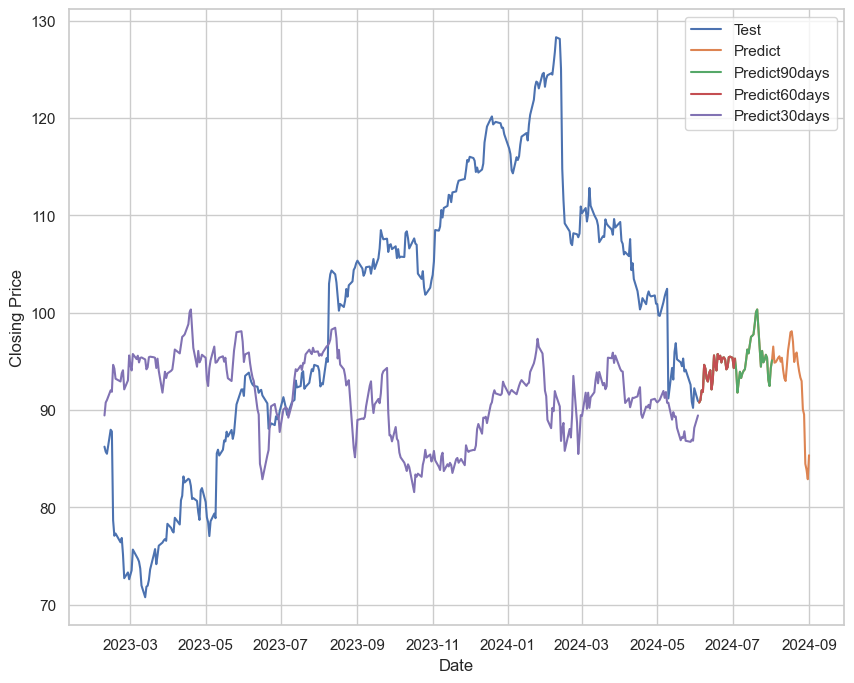

In [22]:
#Vẽ hình
plt.figure(figsize=(10, 8))
plt.plot(test_akam_df['close'])
plt.plot(forecast_90_days)
plt.plot(forecast_60_days)
plt.plot(forecast_30_days)
plt.plot(test_predictions)
plt.legend(['Test','Predict','Predict90days', 'Predict60days', 'Predict30days'])
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)
plt.show()

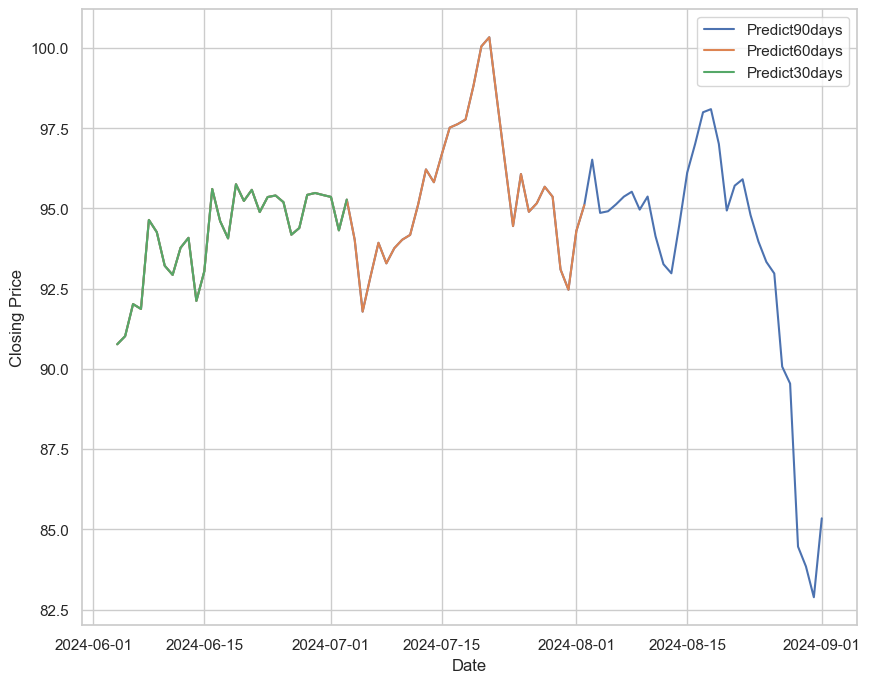

In [23]:
#Vẽ hình
plt.figure(figsize=(10, 8))
plt.plot(forecast_90_days)
plt.plot(forecast_60_days)
plt.plot(forecast_30_days)
plt.legend(['Predict90days', 'Predict60days', 'Predict30days'])
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)
plt.show()